In [1]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import join as os_join
import pandas as pd

from source.model import BeamModel
import source.postprocess as postprocess
from source.utilities import utilities as utils
from source.Querschnitte import nEck, KreisRing
import source.utilities.global_definitions as GD
from source.utilities import holz


2D Euler-Bernoulli Balken:

x-Achse: Längsrichtung
y-Achse: Querrichtung
gamma: Verdrehung
Biegung um z-Achse
(keine Torsion)

![Balken](Beschreibungen/Balken_cosy_klein.png)

# Definieren der (Grund) Geometrischen sowie der Material Parameter

Abschnittsweise veränderliche Querschnittswerte werden nach erstellen der Querschnitte nEck und KreisRing ergänzt: 'defined on intervals'

Derzeit macht es vieles einfacher wenn die Anzahl der elemente des Balken 'n_elements' gleich der Ebenen anzahl des Modells ist. 


In [2]:
parameters = {
               'dimension': '2D',
                'n_elements': 13,
                'lx_total_beam': 110,
                'material_density': 904,# 500,#42, #für dynamische Berechnung äquivalenter Wert
                'total_mass_tower': 668390,# aus RFEM
                'nacelle_mass': 287920.5,# RFEM: 267910,# IEA37: 191000, # Gondel Masse in kg
                'vorspannkraft':12*2.5E+06, # N
                'E_Modul': 12000E+06,# N/m²
                'nu': 0.1, # querdehnung
                'damping_coeff': 0.025,
                'nodes_per_elem': 2,
                'cross_section_area': 12*12, #Not used if intervals
                'Iz': 51.0,#*0.33333,
                'dofs_of_bc':[0,1,2], # Einspannung
                'type_of_bc':'clamped',#'clamped',# or 'spring'
                'spring_stiffness':[1E+13,2E+13], # Federsteifigkeit am Boden in u und gamma richtung
                'dynamic_load_file': os_join(*["inputs","forces","dynamic_force_11_nodes.npy"]),
                'eigen_freqs_target':[0.133,0.79,3.0], 
                'defined_on_intervals':[] # kann gefüllt werden mit einer pickle datei 
            }
n_nodes = parameters['n_elements']+1

werkstoff_parameter = holz.charakteristische_werte['BSP_RFEM']
parameters['material_density'] = werkstoff_parameter['rhok']
parameters['E_Modul'] = werkstoff_parameter['E0mean']

nachweis_parameter = holz.HOLZBAU

# Ergebnisse in einem DataFrame speichern - reihe = Höhe; Spalte = Ergebniss
# TODO: den Spalten namen mehrere Level geben Name, einheit, Querschnittstyp z.B. 
# https://stackoverflow.com/questions/32370402/giving-a-column-multiple-indexes-headers 
results_df = pd.DataFrame()
grund_parameter_df = pd.DataFrame() # grundlegende parameter die untersucht werden
results_excel = os_join(*['output','Berechnungs_Ergebnisse.xlsx'])

# Querschnittsdefinition

- mit create_cross_sections.py können Querschnitte (nEck und KreisRing) erstellt werden und als dictonary in einer pickle Datei gespeichert. (Gedacht für den Systematischen Vergleich mehrerer QS)
- Querschnitte müssen immer über Querschnitt.export_to_dict_pkl() gespeichert werden 
- diese müssen geladen werden (eindeutige Identifikation über den Namen der Datei) und den aktuellen parametern angehängt werden (wird diese Funktion verwendet werden nötige Variablen wie die totale länge automatisch angepasst)

Sollen mehrere Querschnitte untersucht werden ist gedacht eine Liste an Dateien mit den unterschiedlichen Querschnitten zu erstellen.

        Alternative 1: Querschnitte Laden aus Dateien erstellt mit "create_cross_sections.py"

In [3]:
ecken = [12] #8,10,
höhen = [110]#,130,140,150,160]
querschnitte = {}#, 'Kreisring_d12.pkl']#'8Eck.pkl','10Eck.pkl', 
for höhe in höhen:
    #querschnitte.append('Ring_'+str(höhe)+'_du12.pkl')
    for n_ecken in ecken:
        querschnitte[str(n_ecken) + 'Eck_' + 'h'+ str(höhe) + '_du12.pkl'] = str(n_ecken) + 'Eck_' + 'h'+ str(höhe) + '_du12.pkl'
        querschnitte['Ring_' + str(höhe) + '_du12.pkl'] = 'Ring_' + str(höhe) + '_du12.pkl'

        Alternative 2: Direkt definieren eines / mehrerer Querschnitte

In [4]:
querschnitte = {}
d_oben = 3.4 # durchmesser am Kopf immer so
d_unten = 12 
n_ebenen = 14
if n_ebenen != n_nodes:
        print ('WARNING: besser gleich viele Ebenen wie Knoten für die Berechnung')
höhen_parameter = {}
d_achse = np.linspace(12, 3.4, n_ebenen)
t_wand = 0.4
einheiten_input = {'Kraft':'N', 'Moment':'Nm', 'Festigkeit':'N/mm²', 'Länge':'m'}

lagen_aufbau = [{'ortho':'X','ti':0.16},
                {'ortho':'Y','ti':0.04},
                {'ortho':'X','ti':0.08},
                {'ortho':'Y','ti':0.04},
                {'ortho':'X','ti':0.16}]

m2cm = utils.unit_conversion('m','cm')
t_laengslagen = sum([lage['ti'] for lage in lagen_aufbau if lage['ortho'] == 'X'])
t_querlagen = sum([lage['ti'] for lage in lagen_aufbau if lage['ortho'] == 'Y'])
t = (t_laengslagen + t_querlagen) * m2cm
grund_parameter_df['t [cm]'] = [t] *2

höhe = parameters['lx_total_beam']
höhen_parameter['absolute_höhen'] = np.linspace(0, höhe, n_ebenen)
höhen_parameter['hfract'] = höhen_parameter['absolute_höhen']/höhen_parameter['absolute_höhen'][-1]
destination = os_join(*['inputs','geometry'])

kreis_ring = KreisRing(d_achse, lagen_aufbau=lagen_aufbau,
                        holz_parameter = werkstoff_parameter, 
                        nachweis_parameter = nachweis_parameter,
                        hoehen_parameter= höhen_parameter, einheiten=einheiten_input)
ring_name = 'Ring_h' + str(höhe) + '_du' + str(d_unten)  + '_tX' + str(t_laengslagen*m2cm) + '.pkl'                        
kreis_ring.export_to_dict_pkl(dest_file = os_join(*[destination, ring_name]))


n_ecken = 12                     
current_nEck = nEck(n_ecken, d_achse, lagen_aufbau=lagen_aufbau, 
                        holz_parameter = werkstoff_parameter, 
                        nachweis_parameter = nachweis_parameter,
                        hoehen_parameter= höhen_parameter, einheiten=einheiten_input)
nEck_name = str(n_ecken) + 'Eck_' + 'h'+ str(höhe) + '_du' + str(d_unten) + '_tX' + str(t_laengslagen*m2cm) + '.pkl'
current_nEck.export_to_dict_pkl(dest_file = os_join(*[destination, nEck_name]))

querschnitte[nEck_name] = current_nEck
querschnitte[ring_name] = kreis_ring

results_df['z_coords'] = höhen_parameter['absolute_höhen']



Saved nEck Daten in inputs\geometry\Ring_h110_du12_tX40.0.pkl

Saved nEck Daten in inputs\geometry\12Eck_h110_du12_tX40.0.pkl


# Äußere Belastung 


Windkraft F_w über die Höhe wird nach DIN berechnet (cscd vernachlässigt Bert = 1.01).

![Formel](Beschreibungen/Fw_formel.PNG)
    
Angabe eines eigenen cd / cf Werts (drag coefficient bzw. Kraftbeiwert)

Kopflasten aus IEA37 Min/Max Tabellen

(Für die Statische Analyse des Balkens wird der datei name der Lastdatei übergeben.)

Windbelastung aus:
    vb: 17
    terrain: II
    cd: 1.5
Resultierendes Fy aus Knotenlasten nEck mit cd 1.5 : 654.6769171014452 [kN]
Windbelastung aus:
    vb: 17
    terrain: II
    cd: 1.1
Resultierendes Fy aus Knotenlasten ring mit cd 1.1 : 480.09640587439316 [kN]


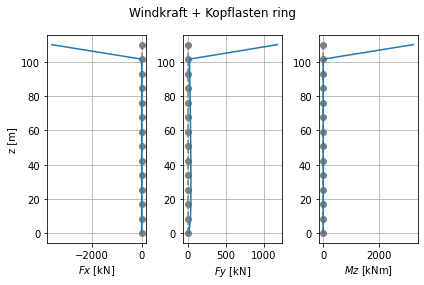

cd_Ring/cd_Eck 0.7333333333333334


In [5]:
kopf_lasten_IEA = {'Fx':1.17E+06,'Fy':4.80E+04, 'Fz':-3.64E+06, 'Mx':5.98E+06, 'My':-3.24E+06, 'Mz':2.31E+06}
kopf_lasten_IEA_0 = {'Fx':0,'Fy':0, 'Fz':-0, 'Mx':0, 'My':0, 'Mz':0}
kopf_lasten_beam = utils.convert_coordinate_system(kopf_lasten_IEA) # Koordinaten definiton abweichend
kopf_lasten_beam_0 = utils.convert_coordinate_system(kopf_lasten_IEA_0) # Koordinaten definiton abweichend
lasten_dict_base = {'Fx':np.zeros(n_nodes), 'Fy':np.zeros(n_nodes), 'Mz':np.zeros(n_nodes)}

import source.DIN_Windlasten as wind_DIN

basis_windgeschwindigkeit = 17
terrain_kategorie = 'II'
cd = {'nEck':1.5, 'ring':1.1}
höhen_z = np.linspace(0,parameters['lx_total_beam'], n_nodes)
d_achse = np.linspace(12, 3.4, n_nodes)
#wind_DIN.plot_DIN_all(basis_windgeschwindigkeit, categories=[terrain_kategorie])

wind_kraft_z = {}
lasten_files = {}
grund_parameter_df['Querschnitt'] = ['nEck', 'Ring']
grund_parameter_df['cd'] = cd.values()
for qs, cd_i in cd.items():
    wind_kraft_z, z_coords = wind_DIN.wind_kraft(vb=basis_windgeschwindigkeit, category=terrain_kategorie, height=höhen_z, cd = cd_i, Aref=d_achse)

    knoten_wind_kraft_z = utils.linien_last_to_knoten_last(wind_kraft_z, höhen_z)
    #postprocess.plot_along_height(knoten_wind_kraft_z, z_coords, label='wind_kraft [N]')


    lasten_dict_nur_wind = utils.update_lasten_dict(lasten_dict_base, knoten_wind_kraft_z, kopf_lasten_beam_0)

    lasten_dict_wind_kopf = utils.update_lasten_dict(lasten_dict_base, knoten_wind_kraft_z, kopf_lasten_beam)

    # ____________ LASTEN DATEI GENERIEREN ___________________________
    static_load_vector_file_kopf = utils.generate_kopflasten_file(n_nodes, kopf_lasten_beam, file_base_name='kopflasten_IEA_my_max')
    static_load_vector_file_wind = utils.generate_lasten_file(n_nodes, lasten_dict_nur_wind, file_base_name='wind_lasten_cd' + str(cd_i))
    lasten_files[qs] = utils.generate_lasten_file(n_nodes, lasten_dict_wind_kopf, file_base_name='wind_kopflasten_IEA_my_max_' + qs)

    #load_vector = np.load(static_load_vector_file)

    print ('Windbelastung aus:')
    print ('    vb:', basis_windgeschwindigkeit)
    print ('    terrain:', terrain_kategorie)
    print ('    cd:', cd_i)

    #postprocess.plot_dict_subplots(lasten_dict_nur_wind, höhen_z, title='Windkraft ' + qs, unit='kN')
    print ('Resultierendes Fy aus Knotenlasten ' + qs + ' mit cd', cd_i,':', sum(lasten_dict_nur_wind['Fy']) *GD.UNIT_SCALE['kN'], '[kN]')
   
postprocess.plot_dict_subplots(lasten_dict_wind_kopf, höhen_z, title='Windkraft + Kopflasten ' +qs, unit = 'kN')
print('cd_Ring/cd_Eck', cd['ring']/cd['nEck'])




Vergleich zu IEA Fuß Schnittgrößen:
    Max Fx: My = 128 MNm

# Schnittgrößen

- Balkenmodell initiieren (für jeden Querschnitt)
- Statisch Berechnung -> Schnittgrößen entlang der Höhe
- Berechnung für Lasten welche abhängig vom Querschnitt sind
- Eigengewicht des Turms mitnehmen 



 12Eck_h110_du12_tX40.0.pkl
Gesamt Volumen des Querschnitts [m³]: 609.84
Volumen x Rho x g [MN]: 2.75
Gesamt Gewichtskraft am Fuß [MN]: -2.75
  Frequencies [Hz]: 
    0.369
    3.048
    6.367



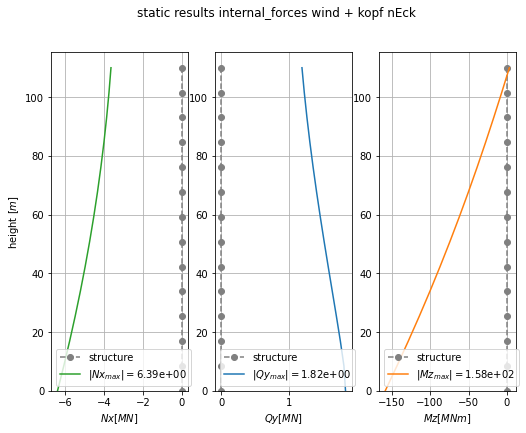


 Ring_h110_du12_tX40.0.pkl
Gesamt Volumen des Querschnitts [m³]: 638.62
Volumen x Rho x g [MN]: 2.88
Gesamt Gewichtskraft am Fuß [MN]: -2.88
  Frequencies [Hz]: 
    0.386
    3.121
    6.493



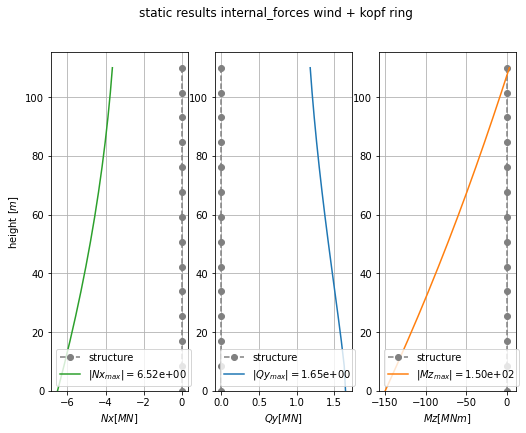

In [6]:
schnittgrößen = {}
for querschnitts_name, querschnitt in querschnitte.items():
    if 'Eck' in querschnitts_name:
        label = 'nEck'
        label_kurz = 'E'
    elif 'Ring' in querschnitts_name:
        label = 'ring'
        label_kurz = 'R'

    print ('\n', querschnitts_name)
    section_properties_pkl = os_join(*['inputs', 'geometry', querschnitts_name])

    parameters = utils.add_model_data_from_pkl(section_properties_pkl, parameters, set_I_eff=False)

    beam = BeamModel(parameters, adjust_mass_density_for_total = False, optimize_frequencies_init=False , apply_k_geo=False)

    print('Gesamt Volumen des Querschnitts [m³]:', round(beam.volume,2))
    print('Volumen x Rho x g [MN]:', round(beam.volume * werkstoff_parameter['rhok'] * GD.GRAVITY * GD.UNIT_SCALE['MN'],2))
    print ('Gesamt Gewichtskraft am Fuß [MN]:',round(sum(beam.eigengewicht * GD.UNIT_SCALE['MN']),2))

    #postprocess.plot_along_height(beam.eigengewicht * GD.UNIT_SCALE['MN'], höhen_z, 'Gewichtskraft Turm [MN]')

    print ('  Frequencies [Hz]: ')
    for i in range (3):
        print ('   ', round(beam.eigenfrequencies[i],3))

    gamma_Q = 1.0 # Da lasten schon mit sichterheitsbeiwerte
    sgr_wind_kopf = beam.static_analysis_solve(load_vector_file=lasten_files[label], return_result=True, add_eigengewicht = True)
    postprocess.plot_static_result_forces(beam, 'internal_forces', ['x','y','g'], unit='MN', title_suffix='wind + kopf ' + label, figsize_scale = 1.3)

    #results_df['Mz ' + label_kurz + ' [MNm]'] = sgr_wind_kopf['g'] * utils.unit_conversion('Nm', 'MNm')
    #results_df['Qy ' + label_kurz + ' [MN]'] = sgr_wind_kopf['y'] * utils.unit_conversion('N', 'MN')
    #results_df['Nx ' + label_kurz + ' [MN]'] = sgr_wind_kopf['x'] * utils.unit_conversion('N', 'MN')

    schnittgrößen[label]=sgr_wind_kopf

# Berechnung der Spannungen

- Für die Liste an Querschnitten werden mit den Entsprechenden Lasten die Spannungen berechnet
- bisher nur Normalspannugen infolge Biegung und Normalkraft
- Ausnutzung aufgrund der Druckspannung aus Moment (Imperfektion) und Normaltkraft 
- TODO Zugspannungen berechnen -> Vorspannkraft einschätzen

In [7]:
for querschnitts_name, querschnitt in querschnitte.items():
    if not isinstance(querschnitt, nEck) and not isinstance(querschnitt, KreisRing):
        querschnitt_object = utils.load_object_pkl(os_join(*['inputs', 'geometry', 'objekte', querschnitt]))
    else:
        querschnitt_object = querschnitt

    if 'Eck' in querschnitts_name:
        last = schnittgrößen['nEck']
        label = 'nEck'
    elif 'Ring' in querschnitts_name:
        last = schnittgrößen['ring']
        label = 'Ring'

    lasten = {
        #maximales  Biegemoment
        'Md': last[GD.RESPONSE_DOF_MAP['Mz']],
        'Mimp':1,
        'Nd':last[GD.RESPONSE_DOF_MAP['Nx']]}

    querschnitt_object.calculate_ausnutzung_normalspannung(lasten)

    results_df[GD.GREEK_UNICODE['sigma'] + '_zug ' + label + ' [' + querschnitt_object.einheiten['Normalspannung'] + ']'] = querschnitt_object.sigma_zug_design
    results_df[GD.GREEK_UNICODE['sigma'] + '_druck ' + label + ' [' + querschnitt_object.einheiten['Normalspannung'] + ']'] = querschnitt_object.sigma_druck_design
    results_df['Ausnutzung druck ' + label] = querschnitt_object.ausnutzung_druck
    results_df[GD.GREEK_UNICODE['sigma'] + '_N ' + label + ' [' + querschnitt_object.einheiten['Normalspannung'] + ']'] = querschnitt_object.sigma_N_design
    results_df['Ausnutzung N ' + label] = querschnitt_object.ausnutzung_N
    results_df[GD.GREEK_UNICODE['sigma'] + '_M ' + label + ' [' + querschnitt_object.einheiten['Normalspannung'] + ']'] = querschnitt_object.sigma_M_design
    results_df['Ausnutzung M ' + label] = querschnitt_object.ausnutzung_M
    

#results_df[GD.GREEK_UNICODE['eta'] + '_Ring/' + GD.GREEK_UNICODE['eta'] + '_nEck'] = results_df['Ausnutzung Ring'] / results_df['Ausnutzung nEck']
print (querschnitts_name)
print()

with pd.ExcelWriter(results_excel, mode= 'w', engine="openpyxl") as writer:#, if_sheet_exists='overlay'
  results_df.to_excel(writer, sheet_name= str(n_ecken)+'Eck-Ring', startrow=4, startcol=0, index=False, float_format='%.4f')
  grund_parameter_df.to_excel(writer, sheet_name= str(n_ecken)+'Eck-Ring', startrow=0, startcol=0, index=False)

utils.zellen_groeße_formatieren(results_excel, worksheet= str(n_ecken)+'Eck-Ring', cell_width=20, n_cols=len(results_df.columns))

print ('Ergebnisse in ', results_excel, 'geschrieben')

QS_label = 'Ring'
print (results_df[[GD.GREEK_UNICODE['sigma'] + '_zug ' + label + ' [' + querschnitt_object.einheiten['Normalspannung'] + ']',
                   GD.GREEK_UNICODE['sigma'] + '_druck ' + label + ' [' + querschnitt_object.einheiten['Normalspannung'] + ']',
                   'Ausnutzung druck ' + QS_label,'Ausnutzung M ' + QS_label, 'Ausnutzung N ' + QS_label]])
    

Ring_h110_du12_tX40.0.pkl

Ergebnisse in  output\Berechnungs_Ergebnisse.xlsx geschrieben
    σ_zug Ring [N/mm²]  σ_druck Ring [N/mm²]  Ausnutzung druck Ring  \
0             4.791591             -6.233236               0.428741   
1             4.880615             -6.327777               0.435244   
2             4.963205             -6.421300               0.441677   
3             5.036826             -6.512342               0.447939   
4             5.096379             -6.597182               0.453774   
5             5.133325             -6.669076               0.458719   
6             5.133791             -6.716538               0.461984   
7             5.075158             -6.720193               0.462236   
8             4.919865             -6.647007               0.457202   
9             4.603718             -6.439290               0.442914   
10            4.012651             -5.992677               0.412195   
11            2.933376             -5.109021               